# Comprehensive Experiment: 8 Configurations

This experiment tests all combinations of:
- **Agents**: Greedy vs UCB
- **Roles**: Price-Quantity assignment
- **Partner Prediction**: With vs Without

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload modules to get latest changes
import importlib
import params
import agents
import model

params = importlib.reload(params)
agents = importlib.reload(agents)
model = importlib.reload(model)

from model import NewsVendorModel
# Experiment Configuration: Test all 8 combinations
import importlib
params = importlib.reload(params)
agents = importlib.reload(agents)
model = importlib.reload(model)

from model import NewsVendorModel

# Define all experiment configurations
experiments = [
    # (agent_types, use_partner_prediction, description)
    (['greedy', 'greedy'], False, 'Greedy-Greedy, No Prediction'),
    (['greedy', 'greedy'], True, 'Greedy-Greedy, With Prediction'),
    (['greedy', 'ucb'], False, 'Greedy(P)-UCB(Q), No Prediction'),
    (['greedy', 'ucb'], True, 'Greedy(P)-UCB(Q), With Prediction'),
    (['ucb', 'greedy'], False, 'UCB(P)-Greedy(Q), No Prediction'),
    (['ucb', 'greedy'], True, 'UCB(P)-Greedy(Q), With Prediction'),
    (['ucb', 'ucb'], False, 'UCB-UCB, No Prediction'),
    (['ucb', 'ucb'], True, 'UCB-UCB, With Prediction'),
]

# Store results from all experiments
all_results = []

print(f"Running {len(experiments)} experiments with {params.ROUNDS} rounds each...")
print("=" * 80)

for idx, (agent_types, use_prediction, description) in enumerate(experiments, 1):
    print(f"\n[{idx}/{len(experiments)}] {description}")
    print(f"  Agent types: {agent_types[0]} (price), {agent_types[1]} (quantity)")
    print(f"  Partner prediction: {use_prediction}")
    
    # Set partner prediction mode
    params.USE_PARTNER_PREDICTION = use_prediction
    
    # Create and run model
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    # Collect data
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    # Process agent data
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Calculate performance metrics
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()  # Last 100 rounds
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    
    # Store results
    all_results.append({
        'Config': description,
        'Agent1': agent_types[0],
        'Agent2': agent_types[1],
        'Prediction': use_prediction,
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Cumulative Regret: {final_regret:.2f}")
    print(f"  ✓ Average Profit: {avg_profit:.2f} (Optimal: {params.PROFIT_OPT:.2f})")
    print(f"  ✓ Final Price: {final_price:.2f} (Optimal: {params.P_OPT:.2f})")
    print(f"  ✓ Final Quantity: {final_quantity:.1f} (Optimal: {params.Q_OPT})")

print("\n" + "=" * 80)
print(f"All {len(experiments)} experiments completed!")

# Create summary DataFrame
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Combined_DF'} for r in all_results])
print("\n📊 PERFORMANCE SUMMARY")
print(results_df.to_string(index=False))

Computing optimal benchmarks (this may take a moment)...
Optimal joint: p=18.00, q=40, profit=499.13
Sequential (price-first): p=18.00, q=40, profit=499.13


C:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing optimal benchmarks (this may take a moment)...
Optimal joint: p=18.00, q=40, profit=499.13
Sequential (price-first): p=18.00, q=40, profit=499.13
Computing optimal benchmarks (this may take a moment)...
Optimal joint: p=18.00, q=40, profit=499.13
Sequential (price-first): p=18.00, q=40, profit=499.13
Running 8 experiments with 365 rounds each...

[1/8] Greedy-Greedy, No Prediction
  Agent types: greedy (price), greedy (quantity)
  Partner prediction: False
  ✓ Cumulative Regret: 75682.88
  ✓ Average Profit: 289.96 (Optimal: 499.13)
  ✓ Final Price: 19.69 (Optimal: 18.00)
  ✓ Final Quantity: 31.4 (Optimal: 40)

[2/8] Greedy-Greedy, With Prediction
  Agent types: greedy (price), greedy (quantity)
  Partner prediction: True
  ✓ Cumulative Regret: 68804.31
  ✓ Average Profit: 309.80 (Optimal: 499.13)
  ✓ Final Price: 18.13 (Optimal: 18.00)
  ✓ Final Quantity: 33.7 (Optimal: 40)

[3/8] Greedy(P)-UCB(Q), No Prediction
  Agent types: greedy (price), ucb (quantity)
  Partner predicti

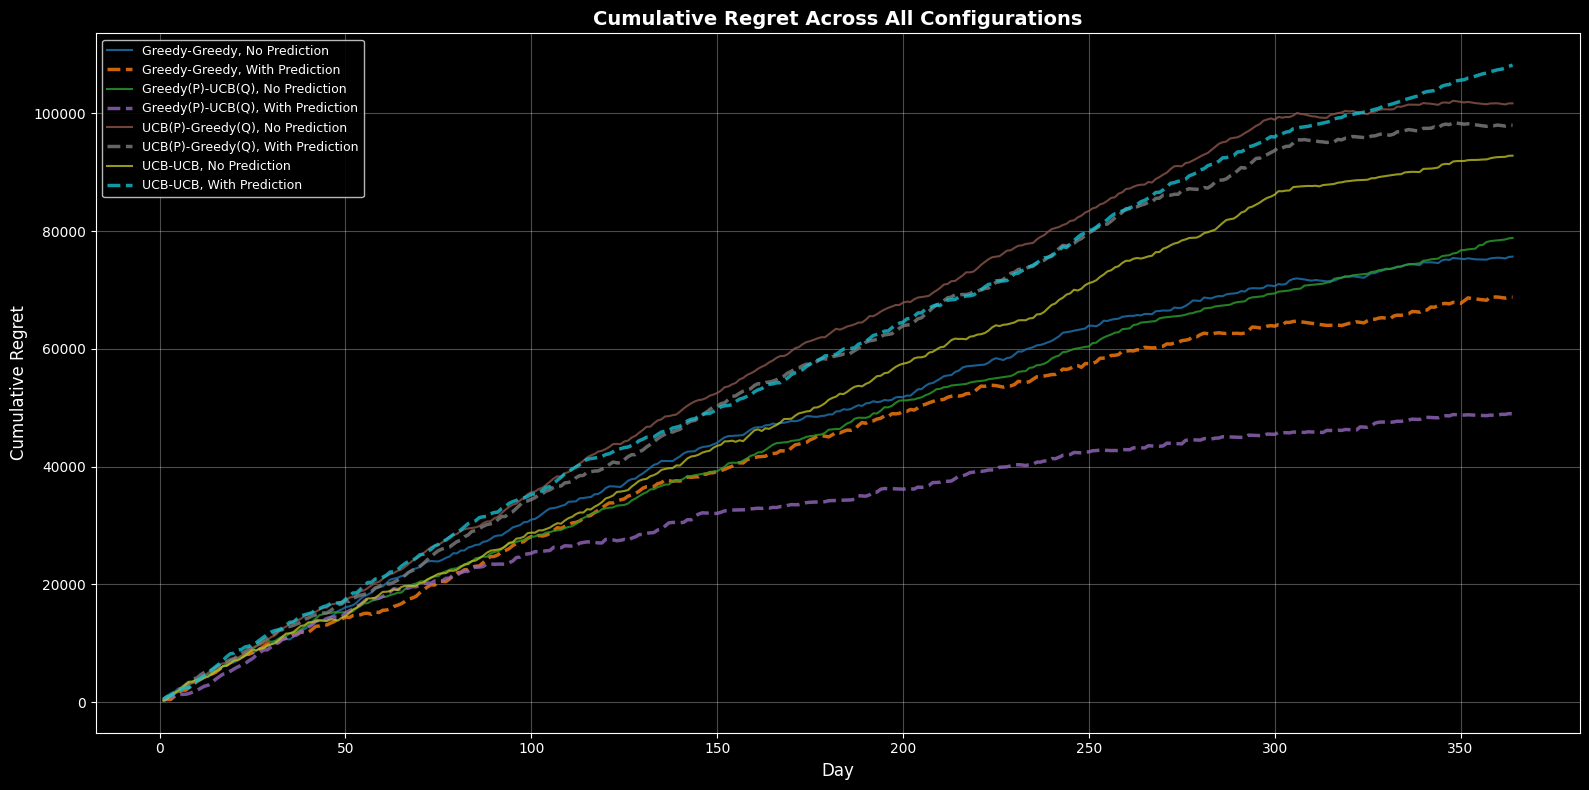

In [2]:
# Visualization 1: Cumulative Regret Comparison
fig, ax = plt.subplots(figsize=(16, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

for idx, result in enumerate(all_results):
    df = result['Combined_DF']
    cumulative_regret = df['Regret'].cumsum()
    
    linestyle = '--' if result['Prediction'] else '-'
    linewidth = 2.5 if result['Prediction'] else 1.5
    
    ax.plot(df['Step'], cumulative_regret, 
            label=result['Config'], 
            color=colors[idx],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=0.8)

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Cumulative Regret', fontsize=12)
ax.set_title('Cumulative Regret Across All Configurations', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

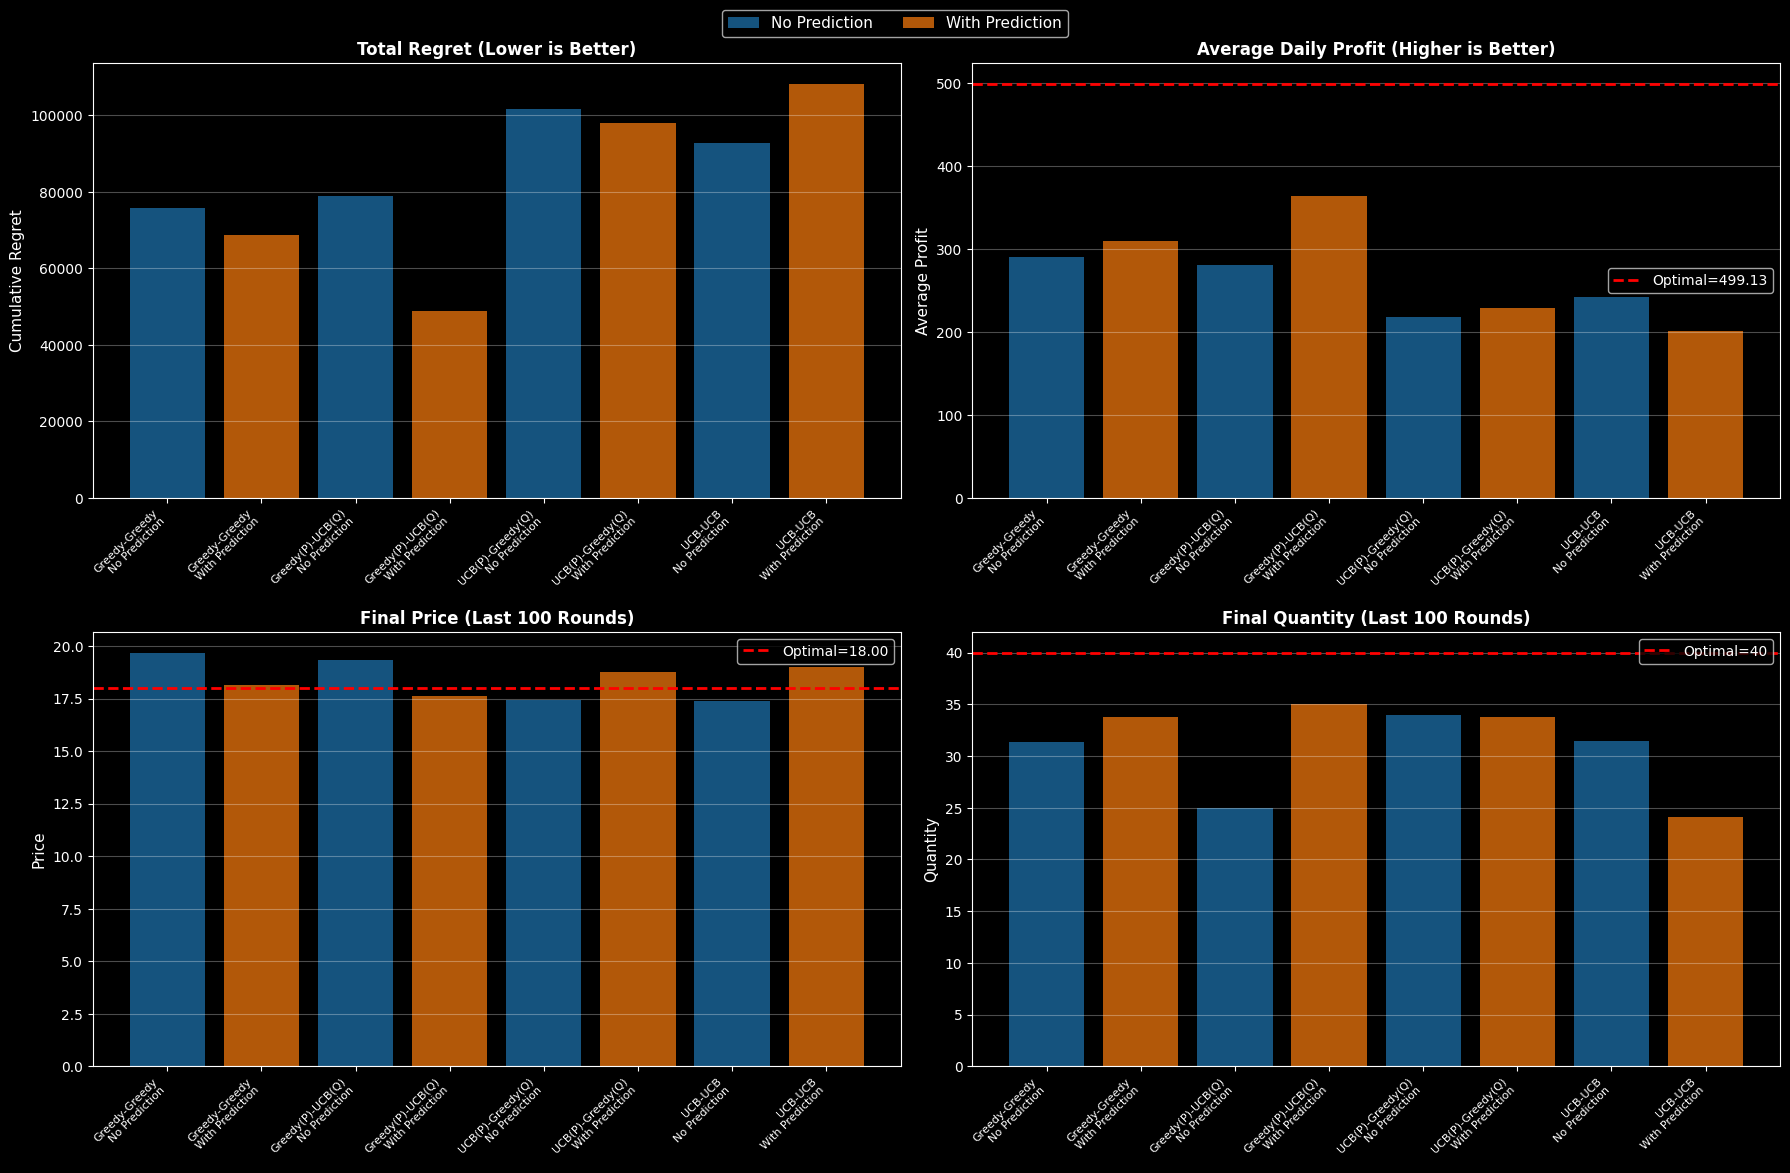

In [3]:
# Visualization 2: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Extract data for plotting
configs = [r['Config'] for r in all_results]
cum_regrets = [r['Cumulative_Regret'] for r in all_results]
avg_profits = [r['Avg_Profit'] for r in all_results]
final_prices = [r['Final_Price'] for r in all_results]
final_quantities = [r['Final_Quantity'] for r in all_results]

x_pos = np.arange(len(configs))
colors_bar = ['#1f77b4' if not r['Prediction'] else '#ff7f0e' for r in all_results]

# 1. Cumulative Regret (lower is better)
axes[0, 0].bar(x_pos, cum_regrets, color=colors_bar, alpha=0.7)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([c.replace(', ', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
axes[0, 0].set_ylabel('Cumulative Regret', fontsize=11)
axes[0, 0].set_title('Total Regret (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average Profit (higher is better)
axes[0, 1].bar(x_pos, avg_profits, color=colors_bar, alpha=0.7)
axes[0, 1].axhline(params.PROFIT_OPT, color='red', linestyle='--', linewidth=2, label=f'Optimal={params.PROFIT_OPT:.2f}')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([c.replace(', ', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
axes[0, 1].set_ylabel('Average Profit', fontsize=11)
axes[0, 1].set_title('Average Daily Profit (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Final Price Convergence
axes[1, 0].bar(x_pos, final_prices, color=colors_bar, alpha=0.7)
axes[1, 0].axhline(params.P_OPT, color='red', linestyle='--', linewidth=2, label=f'Optimal={params.P_OPT:.2f}')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([c.replace(', ', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Price', fontsize=11)
axes[1, 0].set_title('Final Price (Last 100 Rounds)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Final Quantity Convergence
axes[1, 1].bar(x_pos, final_quantities, color=colors_bar, alpha=0.7)
axes[1, 1].axhline(params.Q_OPT, color='red', linestyle='--', linewidth=2, label=f'Optimal={params.Q_OPT}')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([c.replace(', ', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
axes[1, 1].set_ylabel('Quantity', fontsize=11)
axes[1, 1].set_title('Final Quantity (Last 100 Rounds)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# Add legend for color coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', alpha=0.7, label='No Prediction'),
    Patch(facecolor='#ff7f0e', alpha=0.7, label='With Prediction')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

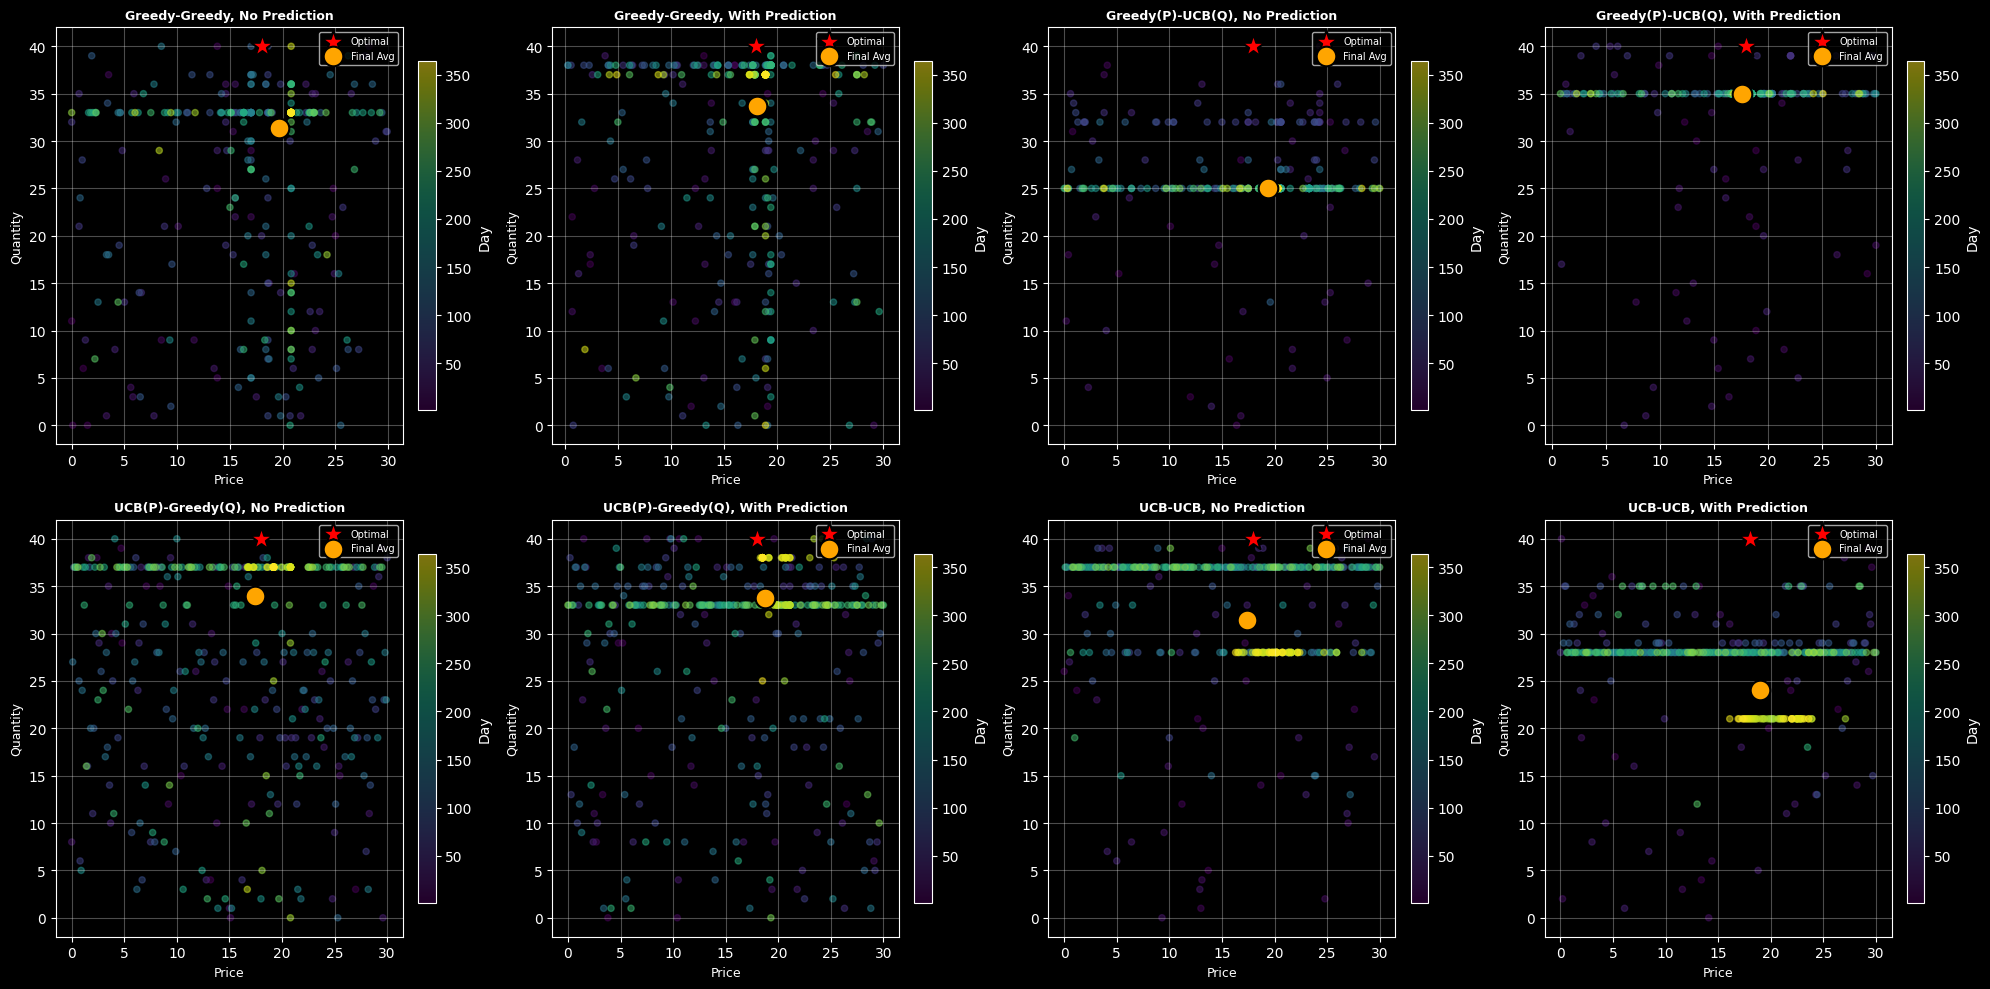

In [4]:
# Visualization 3: Price-Quantity Convergence Trajectories
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    df = result['Combined_DF']
    ax = axes[idx]
    
    # Plot trajectory with color gradient
    scatter = ax.scatter(df['Price'], df['Quantity'], 
                        c=df['Step'], cmap='viridis', 
                        alpha=0.5, s=20)
    
    # Mark optimal point
    ax.scatter([params.P_OPT], [params.Q_OPT], 
              color='red', s=300, marker='*', 
              edgecolors='black', linewidths=1.5,
              label='Optimal', zorder=5)
    
    # Mark final average point
    final_p = result['Final_Price']
    final_q = result['Final_Quantity']
    ax.scatter([final_p], [final_q], 
              color='orange', s=200, marker='o',
              edgecolors='black', linewidths=1.5,
              label='Final Avg', zorder=4)
    
    ax.set_xlabel('Price', fontsize=9)
    ax.set_ylabel('Quantity', fontsize=9)
    ax.set_title(result['Config'], fontsize=9, fontweight='bold')
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Day', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

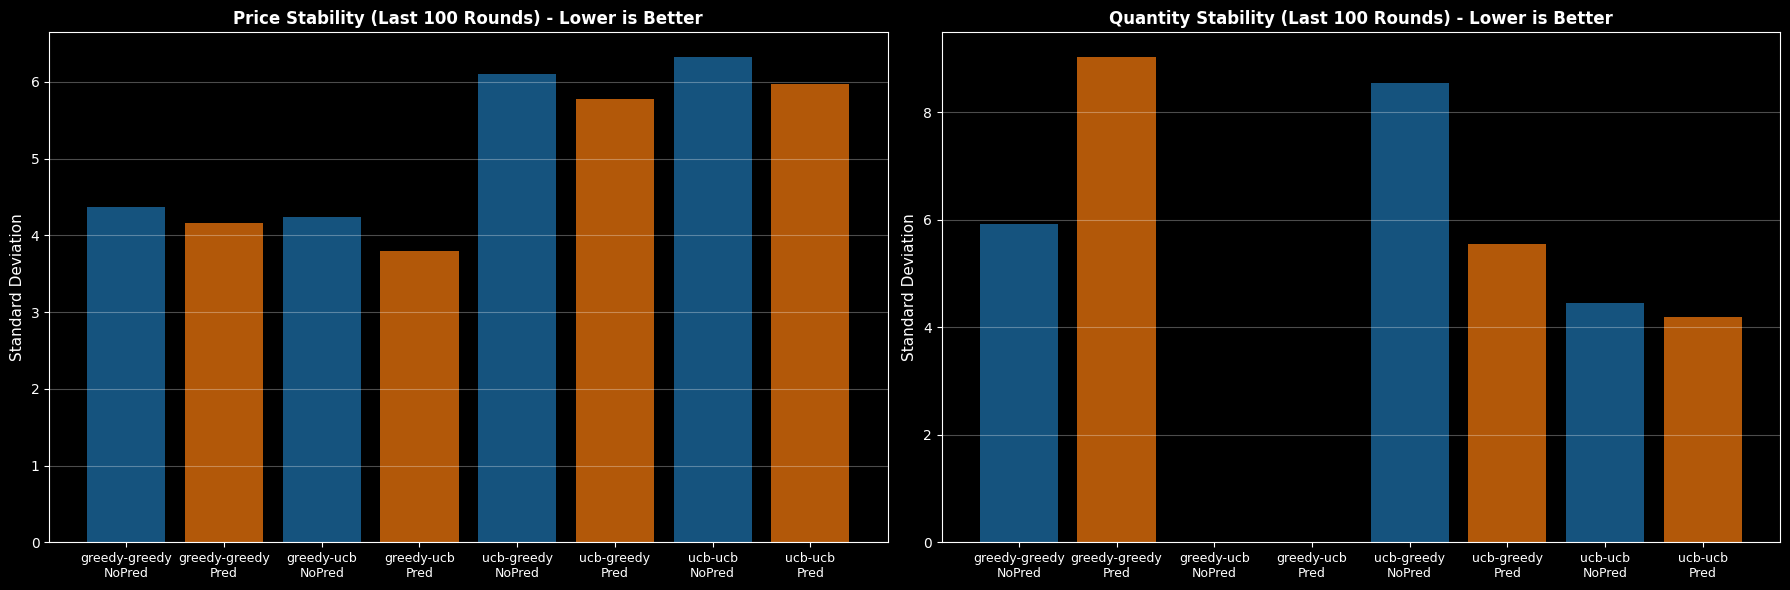

In [5]:
# Visualization 4: Stability Analysis (Price and Quantity Volatility)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

price_stds = [r['Price_Std'] for r in all_results]
qty_stds = [r['Qty_Std'] for r in all_results]
configs_short = [f"{r['Agent1']}-{r['Agent2']}\n{'Pred' if r['Prediction'] else 'NoPred'}" 
                 for r in all_results]

x_pos = np.arange(len(all_results))
colors_stability = ['#1f77b4' if not r['Prediction'] else '#ff7f0e' for r in all_results]

# Price Volatility
ax1.bar(x_pos, price_stds, color=colors_stability, alpha=0.7)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(configs_short, fontsize=9)
ax1.set_ylabel('Standard Deviation', fontsize=11)
ax1.set_title('Price Stability (Last 100 Rounds) - Lower is Better', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Quantity Volatility
ax2.bar(x_pos, qty_stds, color=colors_stability, alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(configs_short, fontsize=9)
ax2.set_ylabel('Standard Deviation', fontsize=11)
ax2.set_title('Quantity Stability (Last 100 Rounds) - Lower is Better', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Summary Analysis: Key Findings
print("=" * 80)
print("🔍 EXPERIMENT SUMMARY & KEY FINDINGS")
print("=" * 80)

# Best performance by cumulative regret
best_config = min(all_results, key=lambda x: x['Cumulative_Regret'])
print(f"\n✅ LOWEST CUMULATIVE REGRET:")
print(f"   Configuration: {best_config['Config']}")
print(f"   Regret: {best_config['Cumulative_Regret']:.2f}")
print(f"   Average Profit: {best_config['Avg_Profit']:.2f}")

# Best average profit
best_profit_config = max(all_results, key=lambda x: x['Avg_Profit'])
print(f"\n✅ HIGHEST AVERAGE PROFIT:")
print(f"   Configuration: {best_profit_config['Config']}")
print(f"   Average Profit: {best_profit_config['Avg_Profit']:.2f}")
print(f"   Regret: {best_profit_config['Cumulative_Regret']:.2f}")

# Most stable (lowest volatility)
stability_scores = [(r['Price_Std'] + r['Qty_Std'], r) for r in all_results]
most_stable = min(stability_scores, key=lambda x: x[0])[1]
print(f"\n✅ MOST STABLE CONFIGURATION:")
print(f"   Configuration: {most_stable['Config']}")
print(f"   Price Std: {most_stable['Price_Std']:.3f}, Quantity Std: {most_stable['Qty_Std']:.3f}")
print(f"   Combined Volatility: {most_stable['Price_Std'] + most_stable['Qty_Std']:.3f}")

# Effect of partner prediction
print(f"\n📊 EFFECT OF PARTNER PREDICTION:")
no_pred = [r for r in all_results if not r['Prediction']]
with_pred = [r for r in all_results if r['Prediction']]

avg_regret_no_pred = np.mean([r['Cumulative_Regret'] for r in no_pred])
avg_regret_with_pred = np.mean([r['Cumulative_Regret'] for r in with_pred])
avg_profit_no_pred = np.mean([r['Avg_Profit'] for r in no_pred])
avg_profit_with_pred = np.mean([r['Avg_Profit'] for r in with_pred])

print(f"   Without Prediction - Avg Regret: {avg_regret_no_pred:.2f}, Avg Profit: {avg_profit_no_pred:.2f}")
print(f"   With Prediction    - Avg Regret: {avg_regret_with_pred:.2f}, Avg Profit: {avg_profit_with_pred:.2f}")
print(f"   Improvement: {((avg_regret_no_pred - avg_regret_with_pred) / avg_regret_no_pred * 100):.1f}% reduction in regret")

# Agent type comparison
print(f"\n🤖 AGENT TYPE COMPARISON:")
agent_type_summary = {}
for r in all_results:
    key = f"{r['Agent1']}-{r['Agent2']}"
    if key not in agent_type_summary:
        agent_type_summary[key] = []
    agent_type_summary[key].append(r)

for agent_combo, results in agent_type_summary.items():
    avg_regret = np.mean([r['Cumulative_Regret'] for r in results])
    avg_profit = np.mean([r['Avg_Profit'] for r in results])
    print(f"   {agent_combo:20s} - Avg Regret: {avg_regret:8.2f}, Avg Profit: {avg_profit:6.2f}")

print("\n" + "=" * 80)
print(f"📈 All configurations achieved average profits between {min(avg_profits):.2f} and {max(avg_profits):.2f}")
print(f"🎯 Optimal profit benchmark: {params.PROFIT_OPT:.2f}")
print(f"📉 Best configuration achieved {(best_profit_config['Avg_Profit']/params.PROFIT_OPT*100):.1f}% of optimal")
print("=" * 80)

🔍 EXPERIMENT SUMMARY & KEY FINDINGS

✅ LOWEST CUMULATIVE REGRET:
   Configuration: Greedy(P)-UCB(Q), With Prediction
   Regret: 48979.01
   Average Profit: 364.38

✅ HIGHEST AVERAGE PROFIT:
   Configuration: Greedy(P)-UCB(Q), With Prediction
   Average Profit: 364.38
   Regret: 48979.01

✅ MOST STABLE CONFIGURATION:
   Configuration: Greedy(P)-UCB(Q), With Prediction
   Price Std: 3.790, Quantity Std: 0.000
   Combined Volatility: 3.790

📊 EFFECT OF PARTNER PREDICTION:
   Without Prediction - Avg Regret: 87275.49, Avg Profit: 258.13
   With Prediction    - Avg Regret: 81000.35, Avg Profit: 276.06
   Improvement: 7.2% reduction in regret

🤖 AGENT TYPE COMPARISON:
   greedy-greedy        - Avg Regret: 72243.59, Avg Profit: 299.88
   greedy-ucb           - Avg Regret: 63917.67, Avg Profit: 322.89
   ucb-greedy           - Avg Regret: 99862.48, Avg Profit: 223.49
   ucb-ucb              - Avg Regret: 100527.94, Avg Profit: 222.12

📈 All configurations achieved average profits between 201.6

In [7]:
# Extract the winning configuration's daily data
best_config = min(all_results, key=lambda x: x['Cumulative_Regret'])

print(f"Winning Configuration: {best_config['Config']}")
print(f"Cumulative Regret: {best_config['Cumulative_Regret']:.2f}")
print(f"Average Profit: {best_config['Avg_Profit']:.2f}")
print("\n" + "=" * 80)

# Get the daily price and quantity data
winning_df = best_config['Combined_DF'][['Step', 'Price', 'Quantity', 'Reward', 'Regret']].copy()
winning_df.columns = ['Day', 'Price', 'Quantity', 'Daily_Profit', 'Daily_Regret']

# Display settings to show full dataframe
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap to multiple lines
pd.set_option('display.max_colwidth', None)  # Show full column content

# Display the dataframe
print(f"\nDaily Price and Quantity for {best_config['Config']} ({len(winning_df)} days):\n")
winning_df

Winning Configuration: Greedy(P)-UCB(Q), With Prediction
Cumulative Regret: 48979.01
Average Profit: 364.38


Daily Price and Quantity for Greedy(P)-UCB(Q), With Prediction (364 days):



,Day,Price,Quantity,Daily_Profit,Daily_Regret
0,1.0,18.9,29.0,461.100000,201.525016
1,2.0,12.3,32.0,297.600000,392.233267
2,3.0,29.2,16.0,106.891749,165.225016
3,4.0,18.9,21.0,333.900000,340.125016
4,5.0,18.9,10.0,159.000000,187.125016
5,6.0,13.4,30.0,312.000000,38.925016
6,7.0,14.8,39.0,460.200000,3.125016
7,8.0,15.4,40.0,496.000000,158.525016
8,9.0,16.1,26.0,340.600000,240.738372
9,10.0,21.3,34.0,258.386643,236.925016
